# Libs

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

# Base vars

In [2]:
ROOT_DIR = '../data/faces/'
PATH_TO_MODEL = '../models/emotion_detection_model_state.pth'

BATCH_SIZE = 128
EPOCHS = 100
BATCH_POINT = 20

MAX_LR = 1e-4

# Processing data

In [3]:
train_transforms = tt.Compose([
    tt.Grayscale(num_output_channels=1), # Картинки чернобелые    
    # Настройки для расширения датасета
    tt.RandomHorizontalFlip(), # Случайные повороты на 90 градусов
    tt.RandomRotation(30),     # Случайные повороты на 30 градусов
    tt.ToTensor()              # Приведение к тензору
])

test_transforms = tt.Compose([
    tt.Grayscale(num_output_channels=1),
    tt.ToTensor()
])

In [4]:
train_dataset = ImageFolder(ROOT_DIR + '/train', train_transforms)

trainDataLoader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)

# View data

In [5]:
# get classes
class_namesList = train_dataset.classes
class_namesList

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


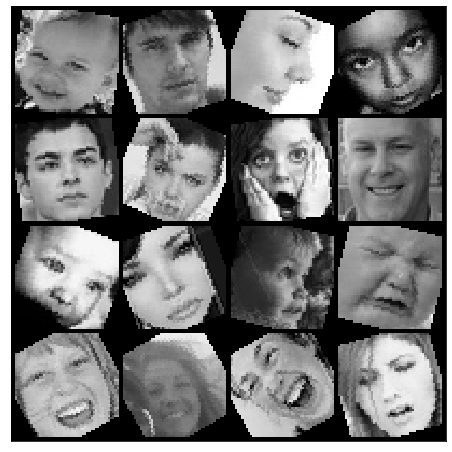

In [7]:
show_batch(trainDataLoader)

# Create model

In [8]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(
            self.conv_block(128, 128), 
            self.conv_block(128, 128)
        ) # Sequential
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(
            self.conv_block(256, 256), 
            self.conv_block(256, 256)
        ) # Sequential
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(
            self.conv_block(512, 512), 
            self.conv_block(512, 512)
        ) # Sequential
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(6), 
            nn.Flatten(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        ) # Sequential
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: 
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [9]:
model = ResNet(1, len(class_namesList))
try:
    model.load_state_dict(torch.load(PATH_TO_MODEL))
    print('model stats loaded')
except FileNotFoundError as err:
    print(err)

model stats loaded


# Learning model

In [10]:
optimizer = torch.optim.Adam(model.parameters(), MAX_LR)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    MAX_LR,
    epochs=EPOCHS,
    steps_per_epoch=len(trainDataLoader)
) # OneCycleLR

In [11]:
print(f'{EPOCHS} epochs, {len(trainDataLoader)} total_steps per epoch')

10 epochs, 225 total_steps per epoch


In [12]:
epoch_losses = []

for epoch in range(EPOCHS):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    
    for batch_idx, (data, labels) in enumerate(trainDataLoader):     
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        _, preds = torch.max(outputs, 1)
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
        if (batch_idx+1) % BATCH_POINT == 0:
            
            torch.save(model.state_dict(), PATH_TO_MODEL)
            
            print(f'Batch {batch_idx+1}, Loss: {running_loss/BATCH_POINT}')
            time2 = time.time()
            
            print(f'Spend time for {BATCH_POINT} batches: {time2 - time1} sec')
            time1 = time.time()
            
            running_loss = 0.0
            
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Batch 20, Loss: 0.003410530912876129
Spend time for 20 batches: 381.8080017566681 sec
Batch 40, Loss: 0.0033752979278564455
Spend time for 20 batches: 296.78034496307373 sec
Batch 60, Loss: 0.0033878138780593873
Spend time for 20 batches: 301.58782172203064 sec
Batch 80, Loss: 0.003385160744190216
Spend time for 20 batches: 309.5765302181244 sec
Batch 100, Loss: 0.003366594898700714
Spend time for 20 batches: 304.37827134132385 sec
Batch 120, Loss: 0.003368785846233368
Spend time for 20 batches: 304.368528842926 sec
Batch 140, Loss: 0.003327281892299652
Spend time for 20 batches: 358.2726900577545 sec
Batch 160, Loss: 0.003375383508205414
Spend time for 20 batches: 314.36982798576355 sec
Batch 180, Loss: 0.003388941705226898
Spend time for 20 batches: 297.46097230911255 sec
Batch 200, Loss: 0.003395062959194183
Spend time for 20 batches: 292.52761006355286 sec
Batch 220, Loss: 0.003371541368961334
Spend time for 20 batches: 307.27159309387207 sec
Epoch 1, loss:  1.6880333842171562
Batc

KeyboardInterrupt: 

Text(0.5, 1.0, 'losses vs. No. of epochs')

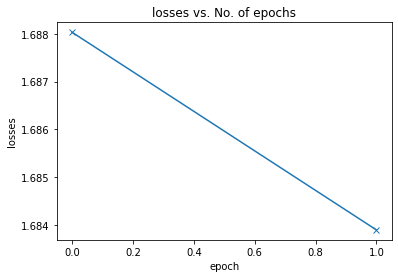

In [13]:
losses = [np.mean(loss) for loss in epoch_losses]

plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [14]:
torch.save(model.state_dict(), PATH_TO_MODEL)